Welcome to Stock Price Predictor!
Fetching data for AAPL...
Data fetched: 502 records from 2023-11-15 to 2025-11-14
Fitting ARIMA model...
ARIMA model fitted successfully.
Forecast generated successfully.

=== Recent Stock Prices (Last 5 Days) ===
2025-11-10: $269.43
2025-11-11: $275.25
2025-11-12: $273.47
2025-11-13: $272.95
2025-11-14: $272.41

=== Forecast (Next 5 Days) ===
2025-11-17: $199.58
2025-11-18: $199.04
2025-11-19: $198.83
2025-11-20: $198.86
2025-11-21: $198.97

=== ASCII Forecast Trend ===
Day 1: ************************************************** $199.58
Day 2: **************                                     $199.04
Day 3:                                                    $198.83
Day 4: *                                                  $198.86
Day 5: *********                                          $198.97
ARIMA Test RMSE: 43.70
Model evaluation completed.
Forecast generated successfully.


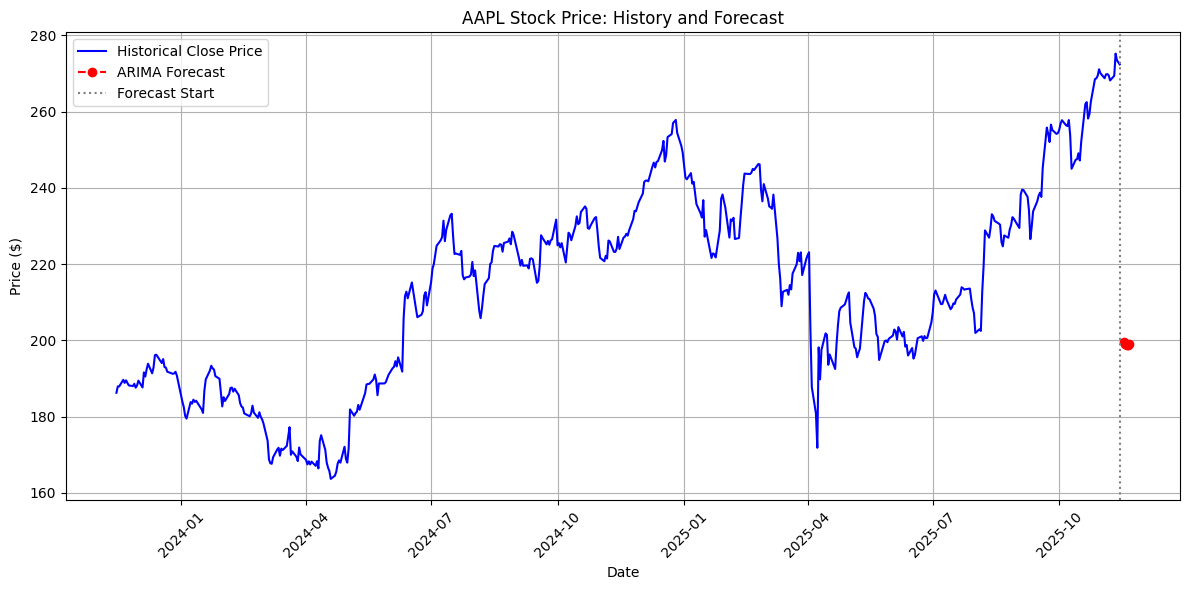

Graphical plot displayed. Close the window to continue.


In [5]:
import sys
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

class StockPredictor:
    def __init__(self):
        self.ticker = None
        self.data = None
        self.model_type = 'ARIMA'  # Default model
        self.arima_model = None
        self.scaler = MinMaxScaler()
        self.forecast_steps = 5  # Number of days to forecast
        self.train_size = 0.8  # Train-test split ratio

    def fetch_data(self, ticker, period='2y'):
        try:
            print(f"Fetching data for {ticker}...")
            stock = yf.Ticker(ticker)
            self.data = stock.history(period=period)
            if self.data.empty:
                raise ValueError(f"No data found for ticker {ticker}. Please check the symbol.")
            self.data = self.data.fillna(method='ffill').dropna()  # Handle missing data
            self.data = self.data['Close'].to_frame()  # Use closing prices only
            print(f"Data fetched: {len(self.data)} records from {self.data.index[0].date()} to {self.data.index[-1].date()}")
            return True
        except Exception as e:
            print(f"Error fetching data: {e}")
            return False

    def preprocess_data(self):
        if self.data is None or self.data.empty:
            return False
        n = len(self.data)
        self.train_size_abs = int(n * self.train_size)
        self.train = self.data.iloc[:self.train_size_abs]
        self.test = self.data.iloc[self.train_size_abs:]
        # Check for any NaNs in train/test sets and handle
        if self.train['Close'].isnull().any() or self.test['Close'].isnull().any():
            print("Null values found in training or testing data; dropping them.")
            self.train = self.train.dropna()
            self.test = self.test.dropna()
        return True

    def fit_arima(self, order=(5,1,0)):
        try:
            print("Fitting ARIMA model...")
            self.arima_model = ARIMA(self.train['Close'], order=order).fit()
            print("ARIMA model fitted successfully.")
            return True
        except Exception as e:
            print(f"Error fitting ARIMA: {e}")
            return False

    def forecast_arima(self):
        if self.arima_model is None:
            return None

        # Use predict for out-of-sample forecast to fix NaN issue
        start = len(self.train)
        end = start + self.forecast_steps - 1
        forecast = self.arima_model.predict(start=start, end=end)
        
        # Ensure forecast length and index correctness
        forecast_index = pd.date_range(start=self.data.index[-1] + pd.Timedelta(days=1),
                                       periods=self.forecast_steps, freq='B')
        
        forecast_df = pd.DataFrame({'Forecast': forecast.values}, index=forecast_index)
        
        # Diagnostics print for NaN values
        if forecast_df['Forecast'].isnull().any():
            print("Warning: Forecast contains NaN values!")
        else:
            print("Forecast generated successfully.")
        
        return forecast_df

    def evaluate_model(self):
        if self.model_type == 'ARIMA' and self.arima_model:
            test_pred = self.arima_model.predict(start=len(self.train), end=len(self.data)-1)
            rmse = np.sqrt(mean_squared_error(self.test['Close'], test_pred))
            print(f"ARIMA Test RMSE: {rmse:.2f}")
        print("Model evaluation completed.")

    def visualize_terminal(self, forecast_df):
        if forecast_df is None:
            return
        print("\n=== Recent Stock Prices (Last 5 Days) ===")
        recent = self.data.tail(5)
        for date, close in recent['Close'].items():
            print(f"{date.date()}: ${close:.2f}")

        print("\n=== Forecast (Next 5 Days) ===")
        for date, pred in forecast_df['Forecast'].items():
            print(f"{date.date()}: ${pred:.2f}")

        forecasts = forecast_df['Forecast'].values
        min_val, max_val = min(forecasts), max(forecasts)
        scale = 50
        print("\n=== ASCII Forecast Trend ===")
        for i, val in enumerate(forecasts):
            norm = int((val - min_val) / (max_val - min_val) * scale) if max_val > min_val else scale // 2
            bar = '*' * norm + ' ' * (scale - norm)
            print(f"Day {i+1}: {bar} ${val:.2f}")

    def plot_graph(self):
        if self.data is None or self.data.empty:
            print("No data available. Fetch data first.")
            return
        forecast_df = None
        if self.model_type == 'ARIMA' and self.arima_model:
            forecast_df = self.forecast_arima()

        if forecast_df is None:
            print("No forecast available. Fit a model first.")
            plt.figure(figsize=(12, 6))
            plt.plot(self.data.index, self.data['Close'], label='Historical Close Price', color='blue')
            plt.title(f'{self.ticker} Stock Price History')
            plt.xlabel('Date')
            plt.ylabel('Price ($)')
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            return
        
        plt.figure(figsize=(12, 6))
        plt.plot(self.data.index, self.data['Close'], label='Historical Close Price', color='blue')
        plt.plot(forecast_df.index, forecast_df['Forecast'], label=f'{self.model_type} Forecast',
                 color='red', linestyle='--', marker='o')
        plt.axvline(x=self.data.index[-1], color='gray', linestyle=':', label='Forecast Start')
        plt.title(f'{self.ticker} Stock Price: History and Forecast')
        plt.xlabel('Date')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        print("Graphical plot displayed. Close the window to continue.")

def main():
    predictor = StockPredictor()
    print("Welcome to Stock Price Predictor!")
    ticker = input("Enter stock ticker symbol (e.g., AAPL): ").strip().upper()
    if not predictor.fetch_data(ticker):
        print("Failed to fetch initial data. Exiting.")
        sys.exit(1)
    predictor.ticker = ticker
    if not predictor.preprocess_data():
        print("Data preprocessing failed. Exiting.")
        sys.exit(1)
    if not predictor.fit_arima():
        print("ARIMA fitting failed. Exiting.")
        sys.exit(1)
    forecast = predictor.forecast_arima()
    predictor.visualize_terminal(forecast)
    predictor.evaluate_model()
    predictor.plot_graph()

if __name__ == "__main__":
    main()
